In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from fuzzywuzzy import fuzz

import urllib.request
from PIL import Image

c:\Users\User 1\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Read data

In [2]:
movies_df = pd.read_csv('../data/cleaned/cleaned_movies_details.csv', usecols=['title','genres', 'overview', 'year', 'img_url', 'director', 'stars', 'movie_id'])
rating_df = pd.read_csv('../data/cleaned/cleaned_user_rating.csv')
display(rating_df.head(10))

,user_id,movie_id,rating
0,ur127508339,tt7737800,8
1,ur6312156,tt7737800,8
2,ur150453978,tt7737800,1
3,ur18519281,tt7737800,3
4,ur0806494,tt7737800,7
5,ur11166967,tt7737800,8
6,ur23929077,tt7737800,1
7,ur36401655,tt7737800,9
8,ur7806826,tt7737800,4
9,ur126444962,tt7737800,7


In [3]:
movies_df['genres'] = movies_df['genres'].str.replace(',',' ')
movies_df['genres'] = movies_df['genres'].str.replace('Sci-Fi','SciFi')
movies_df['genres'] = movies_df['genres'].str.replace('Film-Noir','FilmNoir')
movies_df['genres'] = movies_df['genres'].str.replace('Reality-TV','RealityTV')
movies_df['genres'] = movies_df['genres'].str.replace('Talk-Show','TalkShow')

In [ ]:
movies_df['content'] = movies_df.apply(
    lambda x: f"{x['title']} is a {x['genres']} movie directed by {x['director']} starring {x['stars']}. Overview: {x['overview']}",
    axis=1
)

# Create a TF-IDF vectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')

# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vector.fit_transform(movies_df['content'])
print(tfidf_matrix.shape)

(19108, 53630)


Next, let's calculate the similarity between two movies using the **tf-idf matrix**. The **cosine similarity** is used to calculate the similarity, and **linear_kernel()** class is used to calculate this.


In [5]:
# create the cosine similarity matrices
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix)
np.save('./sim_matrix.npy', sim_matrix)
print(sim_matrix.shape)

(19108, 19108)


**sim_matrix**$_{ij}$ is the similarity score between movie $i$ and movie $j$. Therefore, the diagonal elements in the matrix represent the similarity scores of a movie with itself, and therefore, the value should be 1. By the definition of the matrix, **sim_matrix**$_{ij}$ = **sim_matrix**$_{ji}$.

In [7]:
def get_movieimg_from_index(index):
    return movies_df[movies_df.index == index]['img_url'].values[0]
def get_index_from_title(title):
    return movies_df[movies_df.title == title].index.values[0]
def get_title_from_index(index):
    return movies_df[movies_df.index == index]['title'].values[0]

In [8]:
# function to find the closest title
def close_score(a,b):
    return fuzz.ratio(a,b)

In [9]:
# function to return the most similar title to the words a user types
def find_closest_title(title):
    leven_scores = list(enumerate(movies_df['title'].apply(close_score, b=title)))
    sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
    closest_title = get_title_from_index(sorted_leven_scores[0][0])
    distance_score = sorted_leven_scores[0][1]
    return closest_title, distance_score

In [10]:
def contents_based_recommender(movie, num_of_recomm=10):
    closest_title, similarity_score = find_closest_title(movie)
    
    if similarity_score != 100:
        print('Did you mean ' + '\033[1m' + str(closest_title) + '\033[0m' + '?', '\n')
        
    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    similar_movies = list(filter(lambda x: x[0] != int(movie_index), sorted(movie_list, key=lambda x: x[1], reverse=True)))
    # Create a 2x5 subplot grid
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Here's the list of movies similar to " + str(closest_title), fontsize=16)

    for i, s in enumerate(similar_movies[:num_of_recomm]):
        url = get_movieimg_from_index(s[0])
        ax = axes[i // 5, i % 5]
        ax.imshow(np.array(Image.open(urllib.request.urlopen(url))))
        plt.xlabel(get_title_from_index(s[0]))
        ax.axis('off')
    plt.show()

Did you mean Spider-Man? 



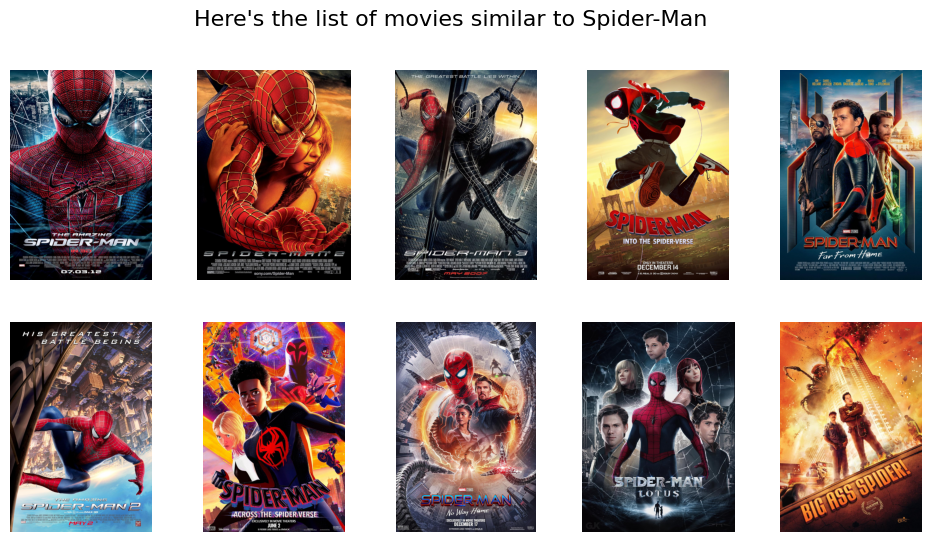

In [16]:
contents_based_recommender('Spider man')